In [1]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as T

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

In [3]:
trainset = MNIST(root='./', train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 282470555.92it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 79694535.41it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 139689579.60it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1023176.80it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.utils.data import DataLoader

In [5]:
batch_size=64

In [6]:
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [7]:
import torch.nn as nn
import matplotlib.pyplot as plt

In [8]:
dataiter = iter(train_dl)
len(next(dataiter))

2

In [9]:
imgs, labels = next(dataiter)

In [10]:
imgs.shape

torch.Size([64, 1, 28, 28])

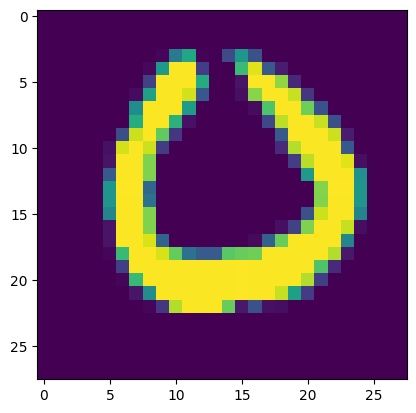

In [11]:
plt.imshow(imgs[0].permute(1,2,0))

In [12]:
labels[0]

tensor(0)

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [14]:
# model = Autoencder_Linear()
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [35]:
def fit(train_dl,model, criterion, optimizer, epochs,linear=False):
  output = []
  for epoch in range(epochs):
    for (img, _) in train_dl:
      if linear:
        img = img.reshape(-1,28*28)
      recon = model(img)
      loss = criterion(recon, img)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    output.append((epoch, img, recon,loss.item()))
    print('epoch:{}, Loss: {},'.format(epoch+1,loss.item()))
  return output

In [36]:
output = fit(train_dl, model, criterion, optimizer,epochs=10)

epoch:1, Loss: 0.9285873174667358,
epoch:2, Loss: 0.9287468194961548,
epoch:3, Loss: 0.9301994442939758,
epoch:4, Loss: 0.9251564741134644,
epoch:5, Loss: 0.9206234812736511,
epoch:6, Loss: 0.9279746413230896,
epoch:7, Loss: 0.9287160038948059,
epoch:8, Loss: 0.9285113215446472,
epoch:9, Loss: 0.9268470406532288,
epoch:10, Loss: 0.9250919818878174,


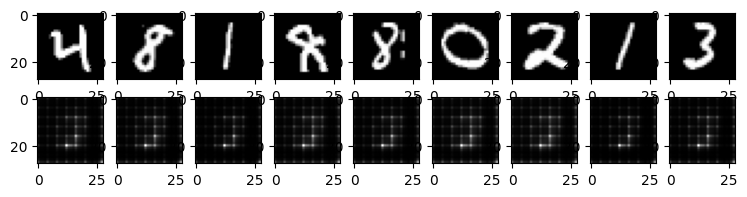

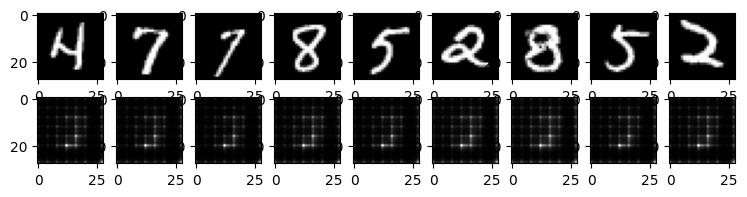

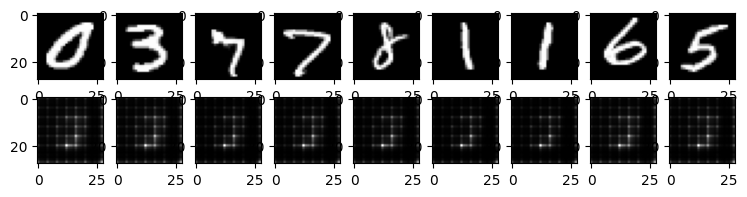

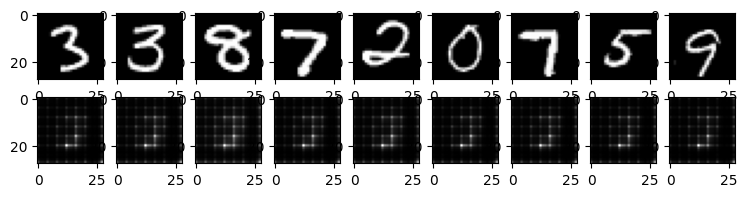

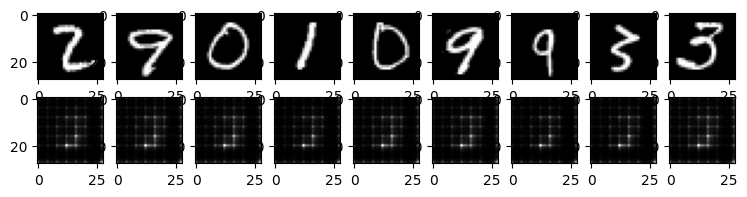

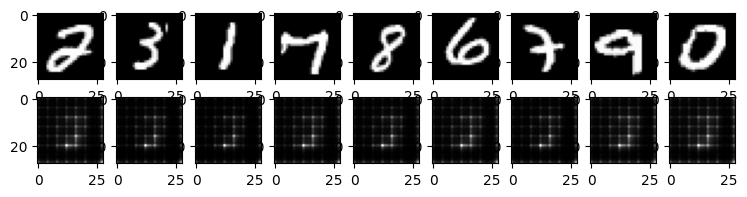

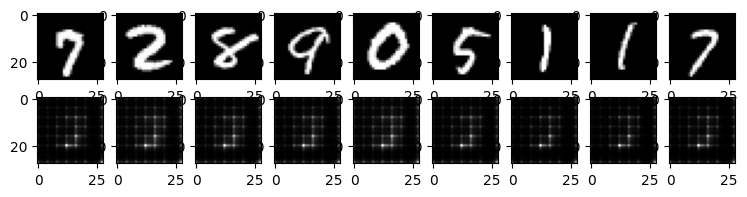

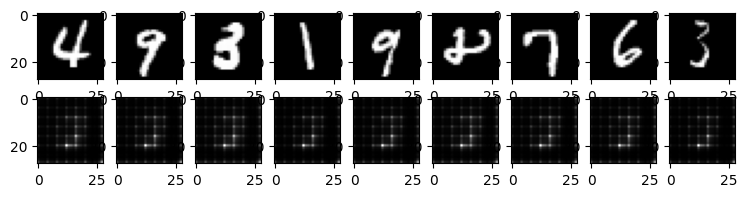

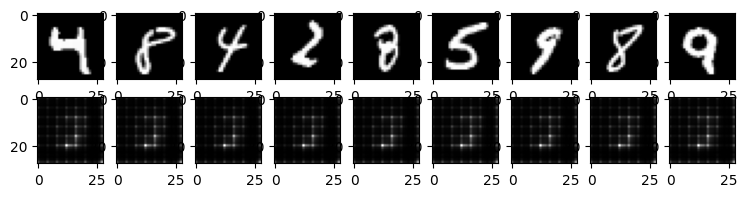

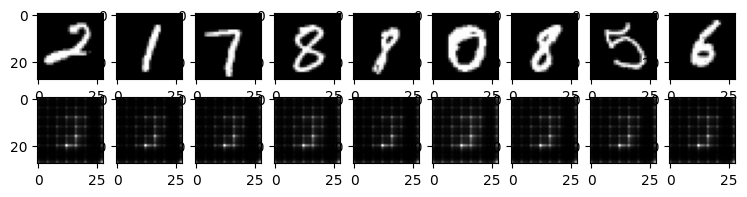

In [37]:
for k in range(0, 10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = output[k][1].detach().numpy()
    recon = output[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [38]:
from torch.nn.modules.activation import Sigmoid
class Autoencoder_Linear(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,3)
    )
    self.decoder = nn.Sequential(
        nn.Linear(3,32),
        nn.ReLU(),
        nn.Linear(32,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    encode = self.encoder(x)
    decode = self.decoder(encode)
    return decode

In [39]:
linear_model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01, weight_decay=0.01)

In [40]:
linear_outputs = fit(train_dl, linear_model, criterion, optimizer,epochs=10,linear=True)

epoch:1, Loss: 0.927434504032135,
epoch:2, Loss: 0.9265782833099365,
epoch:3, Loss: 0.9252785444259644,
epoch:4, Loss: 0.9279502034187317,
epoch:5, Loss: 0.9313501119613647,
epoch:6, Loss: 0.9332153797149658,
epoch:7, Loss: 0.9274436235427856,
epoch:8, Loss: 0.9222669005393982,
epoch:9, Loss: 0.9341320395469666,
epoch:10, Loss: 0.9274169206619263,


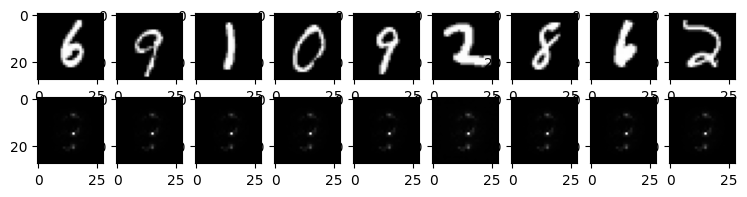

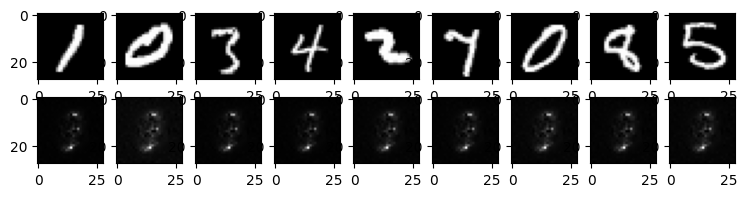

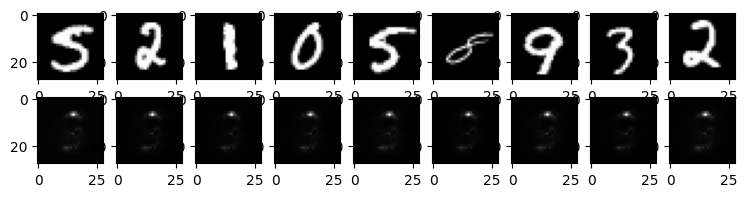

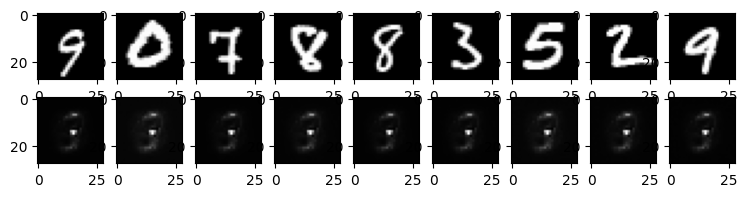

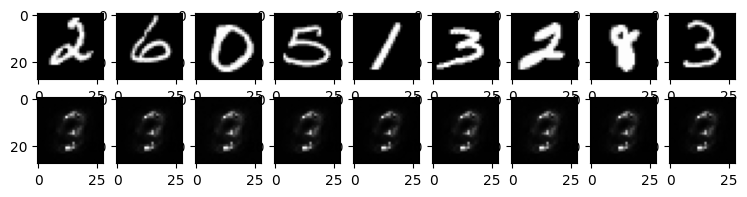

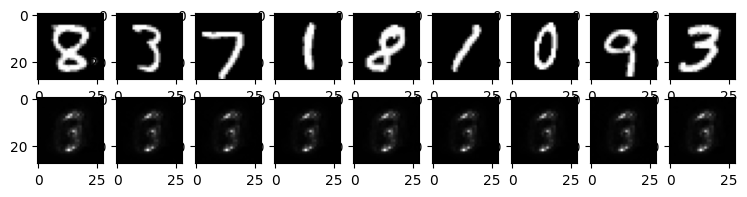

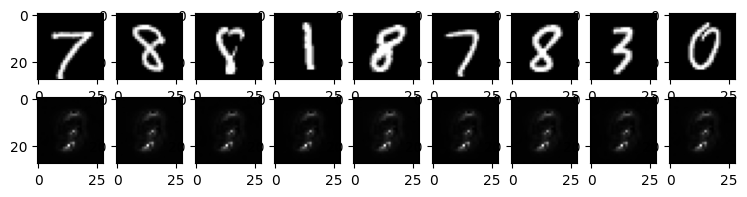

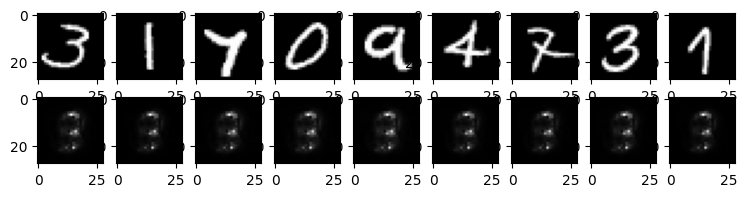

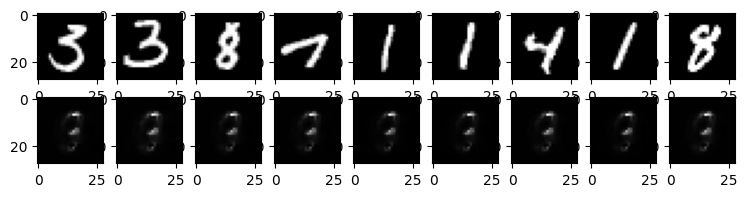

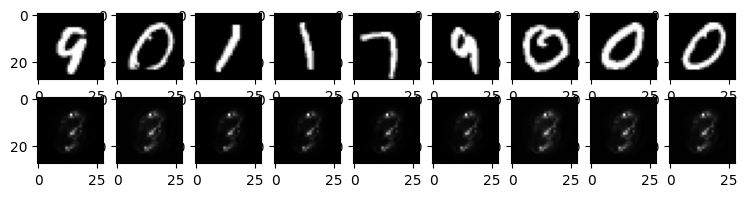

In [41]:
for k in range(0, 10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = linear_outputs[k][1].detach().numpy()
    recon = linear_outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])